# FINAL NPZD PROTOTYPE

In [1]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [2]:
from phydra.components.variables import SV
from phydra.components.fluxes import LinearInput, LinearMortality, ExponentialGrowth, MonodGrowth

In [3]:
import numpy as np

In [20]:
NPZD = phydra.create({'Nutrient':SV, 
                      'Phytoplankton':SV,
                      'Zooplankton':SV,
                      'Detritus':SV,

                      'Input':LinearInput, 'Mortality':LinearMortality,

                      'NutrientUptake':MonodGrowth})

In [21]:
NPZD

<xsimlab.Model (10 processes, 17 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) sequence of time points fo...
Nutrient
    var_init        [in] initial value /basic state variable
    var_label       [in] label /basic state variable
Phytoplankton
    var_init        [in] initial value /basic state variable
    var_label       [in] label /basic state variable
Zooplankton
    var_label       [in] label /basic state variable
    var_init        [in] initial value /basic state variable
Detritus
    var_init        [in] initial value /basic state variable
    var_label       [in] label /basic state variable
Input
    rate            [in] linear rate of change
    var             [in] variable affected by flux
Mortality
    rate            [in] linear rate of change
    var             [in] variable affected by flux
NutrientUptake
    resource        [in]
    halfsat         [in]
    consumer        [in]
Solver

In [38]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,100,0.1),
            input_vars={
                'Nutrient':{'var_label':'N','var_init':1.},
                'Phytoplankton':{'var_label':'P','var_init':1.},
                'Zooplankton':{'var_label':'Z','var_init':1.},
                'Detritus':{'var_label':'D','var_init':1.},
                
                'Input':{'var':'N','rate':0.1},
                
                'Mortality':{'var':'P','rate':0.1},
                
                'NutrientUptake':{'resource':'N', 'consumer':'P', 'halfsat':1.5}
            },
            output_vars={'Nutrient__var_value', 'Phytoplankton__var_value', 
                         'Zooplankton__var_value', 'Detritus__var_value',
                        
                         'Input__input_value', 'Mortality__death_value', 'NutrientUptake__uptake_value'}
            )

In [39]:
with NPZD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component Input
Initializing component Mortality
Initializing component NutrientUptake
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x11b6eda60>
start solve now
finalizing: cleanup
Model was solved in 0.016 seconds


In [40]:
odeint_out

<xarray.Dataset>
Dimensions:                       (clock: 2, input_time: 1000, time: 1000)
Coordinates:
  * clock                         (clock) float64 0.0 0.1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type             <U6 'odeint'
    Detritus__var_init            float64 1.0
    Detritus__var_label           <U1 'D'
    Detritus__var_value           (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    Input__input_value            (time) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
    Input__rate                   float64 0.1
    Input__var                    <U1 'N'
    Mortality__death_value        (time) float64 0.1 0.1015 0.1045 ... 0.1 0.1
    Mortality__rate               float64 0.1
    Mortality__var                <U1 'P'
    NutrientUptake__consumer      <U1 'P'
    NutrientUptake__halfsat       float64 1.5
    NutrientUptake__resource      <U1 'N'
    NutrientUptake__uptake_value  (time) float64 0.4 0.4023 0.4064 ... 0.1 0.1
    Nutrient__var_init            float64 1.0
    Nutrient__var_label           <U1 'N'
    Nutrient__var_value           (time) float64 1.0 0.9698 ... 0.1667 0.1667
    Phytoplankton__var_init       float64 1.0
    Phytoplankton__var_label      <U1 'P'
    Phytoplankton__var_value      (time) float64 1.0 1.03 1.06 ... 1.0 1.0 1.0
    Time__time                    (input_time) float64 0.0 0.1 0.2 ... 99.8 99.9
    Zooplankton__var_init         float64 1.0
    Zooplankton__var_label        <U1 'Z'
    Zooplankton__var_value        (time) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0

In [41]:
import matplotlib.pyplot as plt

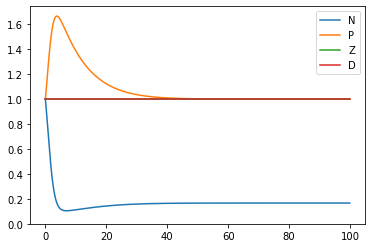

In [42]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Phytoplankton__var_value, label='P')
plt.plot(time, odeint_out.Zooplankton__var_value, label='Z')
plt.plot(time, odeint_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

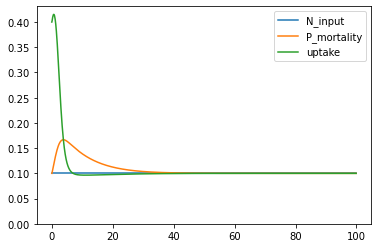

In [43]:
plt.plot(time, odeint_out.Input__input_value, label='N_input')
plt.plot(time, odeint_out.Mortality__death_value, label='P_mortality')
plt.plot(time, odeint_out.NutrientUptake__uptake_value, label='uptake')
plt.ylim(bottom=0)
plt.legend()

In [44]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise")

In [45]:
with NPZD:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component Input
Initializing component Mortality
Initializing component NutrientUptake
assembling model
SOLVER : <phydra.backend.solvers.StepwiseSolver object at 0x11c36d850>
Model contains: 
Variables:['time', 'N', 'P', 'Z', 'D'] 
Parameters:['Input_rate', 'Mortality_rate', 'NutrientUptake_halfsat'] 
Forcings:[] 
Fluxes:['Time_time_flux', 'Input_input', 'Mortality_death', 'NutrientUptake_uptake'] 

finalizing: cleanup
Model was solved in 0.56323 seconds


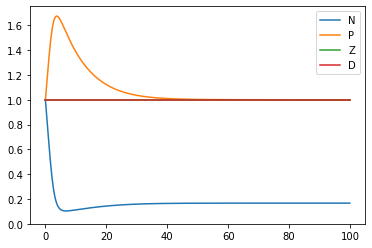

In [46]:
time = stepwise_out.Time__time
plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.plot(time, stepwise_out.Phytoplankton__var_value, label='P')
plt.plot(time, stepwise_out.Zooplankton__var_value, label='Z')
plt.plot(time, stepwise_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

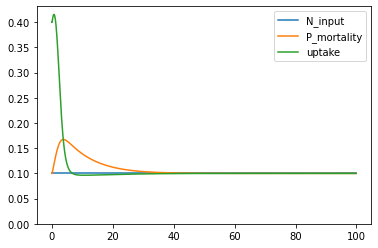

In [47]:
plt.plot(time, stepwise_out.Input__input_value, label='N_input')
plt.plot(time, stepwise_out.Mortality__death_value, label='P_mortality')
plt.plot(time, stepwise_out.NutrientUptake__uptake_value, label='uptake')
plt.ylim(bottom=0)
plt.legend()

In [59]:
gekko_setup = phydra.update_setup(model=NPZD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  new_time=np.arange(0,201))

In [60]:
with NPZD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component Input
Initializing component Mortality
Initializing component NutrientUptake
assembling model
SOLVER : <phydra.backend.solvers.GEKKOSolver object at 0x164a6c940>
['$time=1', '$n=((0+input_rate)+(-((((n)/((n+nutrientuptake_halfsat))))*(p))))', '$p=((0+(-((p)*(mortality_rate))))+((((n)/((n+nutrientuptake_halfsat))))*(p)))', '$z=0', '$d=0']
finalizing: cleanup
Model was solved in 1.63429 seconds


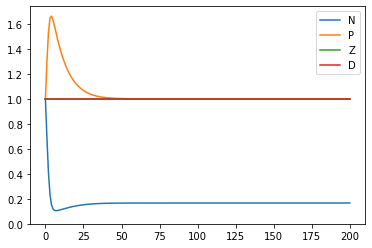

In [61]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.plot(time, gekko_out.Phytoplankton__var_value, label='P')
plt.plot(time, gekko_out.Zooplankton__var_value, label='Z')
plt.plot(time, gekko_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

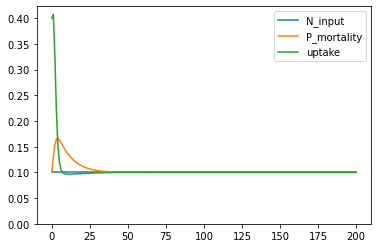

In [62]:
plt.plot(time, gekko_out.Input__input_value, label='N_input')
plt.plot(time, gekko_out.Mortality__death_value, label='P_mortality')
plt.plot(time, gekko_out.NutrientUptake__uptake_value, label='uptake')
plt.ylim(bottom=0)
plt.legend()